Pontificia Universidad Católica de Chile <br>
Departamento de Ciencia de la Computación <br>
IIC2433 - Minería de Datos <br>
Primer Semestre 2025
<br>

<h1><center>Tarea 2: Isolation Forest, HAC, DBSCAN y HDBSCAN </center></h1>
<h3><center>Tomás Romero Aránguiz </center></h3>

        Profesor: Marcelo Mendoza<br>
        Ayudantes encargados: Itzae Flores, Claudia González y Eduardo Salinas.<br>
        Fecha de entrega: 23 de abril del 2025.

## Indicaciones

Deberás entregar **SOLO** el archivo .ipynb en el buzón respectivo en canvas.

**IMPORTANTE**:
- Se te dará puntaje tanto por código como por la manera en la que respondas las preguntas planteadas.
- El notebook debe tener todas las celdas de código ejecutadas.
- Para las preguntas de desarrollo se espera un análisis profundo, no una respuesta superficial.
- El carácter de esta tarea es **INDIVIDUAL**. Cualquier instancia de copia resultará en un 1,1 como nota de curso.

---

## Librerías

In [1]:
##Importa acá las librerias que vayas a utilizar
## De ser necesario, utiliza el comando !pip install a aquellas librerias o modulos que no se encuentren instalados, como puede ser HDBSCAN.
import hdbscan
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import minmax_scale
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering, DBSCAN

warnings.filterwarnings("ignore")

# Introducción

El conjunto de datos corresponde a características extraidas de imagenes de distintos clientes que están buscando pedir un crédito a un banco. Se trabaja con este dataset para predecir si el cliente aceptó o no el último préstamo ofrecido (dado por la columna "Personal Loan") por medio del uso de HAC, DBSCAN, HDBSCAN e Isolation Forest.

En esta tarea deberás trabajar con el dataset Imbalanced Personal Bank Loan Classification que puedes descargar de [Kaggle] (https://www.kaggle.com/code/farzadnekouei/imbalanced-personal-bank-loan-classification) o Canvas.

# Parte 1: Carga y Preprocesamiento de Datos (10 puntos)

En esta primera parte se debe cargar el dataset y luego describir el comportamiento de algunas variables de interés. Posteriormente, debe realizar el proceso de normalización de los datos.

### 1.1 Carga de datos (1 puntos)

In [2]:
df = pd.read_excel('Bank_Personal_Loan_Modelling.xlsx', sheet_name='Data')
df.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [3]:
descripcion = pd.read_excel('Bank_Personal_Loan_Modelling.xlsx', sheet_name='Description', header=None)
descripcion = descripcion[[1,2]]
descripcion.dropna(inplace=True)

### 1.2 Descripcion del Dataset (5 puntos)

#### 1.2.1 Describa brevemente cuantas columnas tiene el dataset y en que consisten las columna del dataset entregado (1 puntos)

In [4]:
print(df.shape)
for fila in descripcion.iterrows():
    print(f"{fila[1][1].upper()}: {fila[1][2]}")

(5000, 14)
ID: Customer ID
AGE: Customer's age in completed years
EXPERIENCE: #years of professional experience
INCOME: Annual income of the customer ($000)
ZIPCODE: Home Address ZIP code.
FAMILY: Family size of the customer
CCAVG: Avg. spending on credit cards per month ($000)
EDUCATION: Education Level. 1: Undergrad; 2: Graduate; 3: Advanced/Professional
MORTGAGE: Value of house mortgage if any. ($000)
PERSONAL LOAN: Did this customer accept the personal loan offered in the last campaign?
SECURITIES ACCOUNT: Does the customer have a securities account with the bank?
CD ACCOUNT: Does the customer have a certificate of deposit (CD) account with the bank?
ONLINE: Does the customer use internet banking facilities?
CREDITCARD: Does the customer use a credit card issued by UniversalBank?


**Respuesta:** 
El dataset cuenta con 14 columnas, las cuales son:
- **ID**: Identificador único.
- **AGE**: Edad.
- **EXPERIENCE**: Años de experiencia profesional.
- **INCOME**: Ingreso anual (en miles de dólares).
- **ZIPCODE**: Código postal del domicilio.
- **FAMILY**: Tamaño del grupo familiar.
- **CCAVG**: Gasto promedio mensual en tarjetas de crédito (en miles de dólares).
- **EDUCATION**: Nivel educativo. 1: Pregrado; 2: Posgrado; 3: Avanzado/Profesional.
- **MORTGAGE**: Valor de la hipoteca de la vivienda, si existe (en miles de dólares).
- **PERSONAL LOAN**: ¿Aceptó el préstamo personal ofrecido en la última campaña?
- **SECURITIES ACCOUNT**: ¿Tiene cuenta de valores con el banco?
- **CD ACCOUNT**: ¿Tiene cuenta de certificado de depósito (CD) con el banco?
- **ONLINE**: ¿Usa servicios de banca por internet?
- **CREDITCARD**: ¿Usa tarjeta de crédito emitida por UniversalBank?


1.2.2 ¿Es posible en este dataset eliminar columnas sin afectar de manera significativa los datos? ¿Por qué? (2 puntos)

**Respuesta:** Creo que es posible eliminar tres columnas sin afectar de manera significativa los datos. Estas serían el *ID*, *ZIPCODE* y *ONLINE*, porque no creo que sean relevantes para el modelo el identificador del cliente, su locación y si utiliza la banca online, ya que es irrelevante para los modelos quien es el cliente. El ZIPCODE, al menos que se haga un estudio geogrefico, no tendra mmucha relacion con nuestro objetivo. Y ONLINE ya que una persona de edad que no utilice estos medios será igual de responsable que otra que si lo utilice.

In [5]:
df.drop(columns=["ID", 'ZIP Code', "Online"], inplace=True)

#### 1.2.3 ¿Por qué crees que es relevante trabajar estos datos? Averigua 3 posibles usos en que trabajar los datos de esta forma podría ser útil para problemas que resuelven las organizaciones (2 puntos)

**Respuesta:** Es importante trabajar con estos datos ya que nos poermite extraer informacion de comportamiento, perfiles y detectar anomalias en los clientes. Tres posibles usos en los que aplicar estos tratamientos de datos son:
- Segmentacion de clientes:  Se normalizan las features y se reduce la dimensionalidad, para luego crear clusters evitando sesgos. Esto permite crear grupos para campañas personalizadas.
- Detección de Fraudes: Se aplican algortimos como Isolation Forest para analizar comportamientos atipicos y transacciones, normalizando datos y filtrando ruido. Se utiliza para identificar patrones sospechosos.
- Gestion de riesos crediticios: Se depuran outliers y se cosifican las variables categorias antes de utilizar HDBSCAN para perfilar clientes segun su riesgo. Clasifica a los solicitantes de prestamos en diferentes grupos basados en su historial y comportamiento

### 1.3 Determinación de valores nulos (1 punto)

Determina si existen datos y/o valores nulos presentes en el dataset. En caso de que existan, realiza el tratamiento pertinente.

In [6]:
df.notna().sum()

Age                   5000
Experience            5000
Income                5000
Family                5000
CCAvg                 5000
Education             5000
Mortgage              5000
Personal Loan         5000
Securities Account    5000
CD Account            5000
CreditCard            5000
dtype: int64

**Respuesta:** Podemos ver que no hay datos nulos, por lo tanto no reciben este tratamiento

### 1.4 Manejo del Dataset (2 puntos)

Normaliza los valores de las columnas del dataset. ¿Por qué esto es importante para el análisis?

In [7]:
df[['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Mortgage']] = minmax_scale(df[['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Mortgage']])
df = pd.get_dummies(df, columns=['Education'], prefix='Edu')
df

,Age,Experience,Income,Family,CCAvg,Mortgage,Personal Loan,Securities Account,CD Account,CreditCard,Edu_1,Edu_2,Edu_3
0,0.045455,0.086957,0.189815,1.000000,0.16,0.000000,0,1,0,0,True,False,False
1,0.500000,0.478261,0.120370,0.666667,0.15,0.000000,0,1,0,0,True,False,False
2,0.363636,0.391304,0.013889,0.000000,0.10,0.000000,0,0,0,0,True,False,False
3,0.272727,0.260870,0.425926,0.000000,0.27,0.000000,0,0,0,0,False,True,False
4,0.272727,0.239130,0.171296,1.000000,0.10,0.000000,0,0,0,1,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.136364,0.130435,0.148148,0.000000,0.19,0.000000,0,0,0,0,False,False,True
4996,0.159091,0.152174,0.032407,1.000000,0.04,0.133858,0,0,0,0,True,False,False
4997,0.909091,0.913043,0.074074,0.333333,0.03,0.000000,0,0,0,0,False,False,True
4998,0.954545,0.934783,0.189815,0.666667,0.05,0.000000,0,0,0,0,False,True,False


**Respuesta** Es importante  normalizar las columnas del dataset por  varias razones: Primero no permite reducir la escala de los datos a valores entre 0 y 1, lo que permite a los modelos ser mas eficientes y eficaces ya que muechas tecnias de ML con sensibles a las diferencias de escala. Tambien permite comparar los resultados con otros modelos, o combinarlos con otros dataset que se encuentre en distintas unidades. Por ejemplo al comparar o juntar con otra tabla o modelo que se haya entrenado con CLP en vez de USD, ya que al reducir estas variables a valore de entre 1 y 0, permite estas comparaciones.

In [8]:
y = df['Personal Loan']
df = df.drop(columns=['Personal Loan'])

# Parte 2: Isolation Forest (15 puntos)

### 2.1 Reduzca la cantidad de componente reteniendo el 95% de la varianza (1 punto)

In [9]:
pca = PCA(n_components=0.95)
X = pca.fit_transform(df)
X.shape

(5000, 8)

### 2.2 Utilizando 100 iTrees, cree una instancia de Isolation Forest. ¿Cuántos outliers detecta Isolation Forest y a qué clases verdaderas pertenecen? (3 puntos)

In [10]:
clf = IsolationForest(n_estimators=100, random_state=0)
clf = clf.fit(X)
y_pred = clf.predict(X)

In [11]:
outliers_indices = np.where(y_pred == -1)[0]
len(outliers_indices)

1208

In [12]:
outliers_true_labels = y.iloc[outliers_indices]
outliers_class_distribution = pd.Series(outliers_true_labels).value_counts()
print(outliers_class_distribution)

Personal Loan
0    900
1    308
Name: count, dtype: int64


Isolation Forest detecta 1208 outliers, de los cuales 900 pertenecen a la clase 0 (clientes que no aceptaron el préstamo personal) y 308 corresponden a la clase 1 (clientes que sí aceptaron el préstamo personal).

### 2.3 ¿Como cambia el numero de de outliers detectados al variar el parametro ```contamination```? Utilize los valores ```[0.01, 0.05, 0.1, 0.2]``` (3 puntos)


In [13]:
anomaly_scores = []
for contamination in [0.01, 0.05, 0.1, 0.2]:
    print(f"\nContaminación: {contamination}")
    clf = IsolationForest(n_estimators=100, contamination=contamination, random_state=0)
    clf = clf.fit(X)
    y_pred = clf.predict(X)  # Devuelve array con 1 (normal) y -1 (outlier)
    outliers_indices = np.where(y_pred == -1)[0]
    print(f'Cantidad de Outliers:{len(outliers_indices)}')
    scores = clf.decision_function(X)
    print(f"Scores: {scores}")
    anomaly_scores.append(scores)
    print("_"*40)


Contaminación: 0.01
Cantidad de Outliers:50
Scores: [0.06736813 0.09332576 0.16136399 ... 0.16968145 0.17486203 0.16363042]
________________________________________

Contaminación: 0.05
Cantidad de Outliers:250
Scores: [0.03881339 0.06477102 0.13280925 ... 0.14112671 0.14630729 0.13507568]
________________________________________

Contaminación: 0.1
Cantidad de Outliers:500
Scores: [-0.00678345  0.01917418  0.08721241 ...  0.09552987  0.10071045
  0.08947884]
________________________________________

Contaminación: 0.2
Cantidad de Outliers:1000
Scores: [-0.05604525 -0.03008762  0.03795061 ...  0.04626807  0.05144865
  0.04021704]
________________________________________


Respuesta: Podemos ver en los resultados, que a medida que aumenta la contaminacion, tambien aumentan la cantidad de outliers detectados

### 2.4 Grafique los "anomaly scores" e indique si se ve un umbral claro (2 puntos)

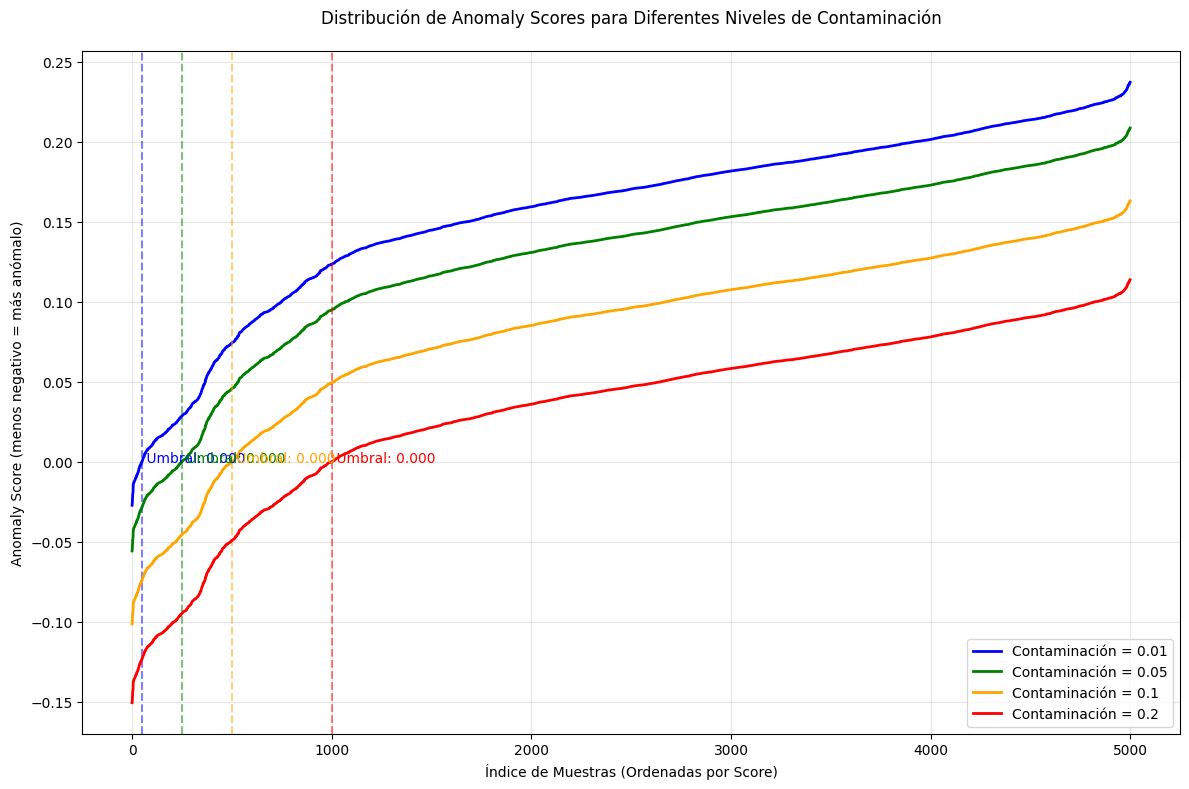

In [14]:
# Configuración del gráfico
plt.figure(figsize=(12, 8))

# Graficar los scores para cada nivel de contaminación
contaminaciones = [0.01, 0.05, 0.1, 0.2]
colores = ['blue', 'green', 'orange', 'red']

for i, (scores, contam) in enumerate(zip(anomaly_scores, contaminaciones)):
    # Ordenar los scores para mejor visualización
    scores_ordenados = np.sort(scores)
    
    # Graficar línea con los scores
    plt.plot(scores_ordenados, 
             label=f'Contaminación = {contam}', 
             color=colores[i],
             linewidth=2)
    
    # Marcar el umbral teórico (donde IsolationForest recorta según la contaminación)
    umbral_idx = int(contam * len(scores))
    if umbral_idx > 0:
        umbral_score = scores_ordenados[umbral_idx]
        plt.axvline(x=umbral_idx, 
                    color=colores[i], 
                    linestyle='--',
                    alpha=0.5)
        plt.text(umbral_idx, 
                 scores_ordenados[umbral_idx], 
                 f' Umbral: {umbral_score:.3f}',
                 color=colores[i])

plt.title('Distribución de Anomaly Scores para Diferentes Niveles de Contaminación', pad=20)
plt.xlabel('Índice de Muestras (Ordenadas por Score)')
plt.ylabel('Anomaly Score (menos negativo = más anómalo)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Podemos ver que para valores mas bajos de contaminacion, el modelo es mas estricto, ya que para valores como 0.01, hay muy pocos valores anomalos. Podemos ver los valores anomalos donde hay valores bajo 0 en eje y. El umbral es claro para cada valor de contaminacion

### 2.5 Que tan estable es la detección de outliers si cambiamos la cantidad de arboles (```n_estimators```) (4 puntos)

In [15]:
for n_trees in [1, 50, 100, 150, 200]:
    
    clf = IsolationForest(n_estimators=n_trees, random_state=0)
    clf = clf.fit(X)
    y_pred = clf.predict(X)  # Devuelve array con 1 (normal) y -1 (outlier)
    outliers_indices = np.where(y_pred == -1)[0]
    
    print(f"\nArboles: {n_trees}")
    print(f'Cantidad de Outliers:{len(outliers_indices)}')
    print("_"*40)


Arboles: 1
Cantidad de Outliers:1244
________________________________________

Arboles: 50
Cantidad de Outliers:1292
________________________________________

Arboles: 100
Cantidad de Outliers:1208
________________________________________

Arboles: 150
Cantidad de Outliers:1254
________________________________________

Arboles: 200
Cantidad de Outliers:1313
________________________________________


La deteccion de outliers no es muy estable cuando cambiamos la cantidad de arboles, como se evidencia anteriormente. Aunque la variacion no sea grande, de igual manera aumentan y disminuyen las cantidades.

### 2.6 Grafique los outliers detectados en las primeras dos componentes principales. (Utilize parametro ```alpha=0.6```) (2 puntos)

In [16]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(df)
X_2d.shape

(5000, 2)

In [17]:
clf = IsolationForest(n_estimators=100, random_state=0)
clf = clf.fit(X_2d)
y_pred = clf.predict(X_2d)  # Devuelve array con 1 (normal) y -1 (outlier)
outliers_indices = np.where(y_pred == -1)[0]

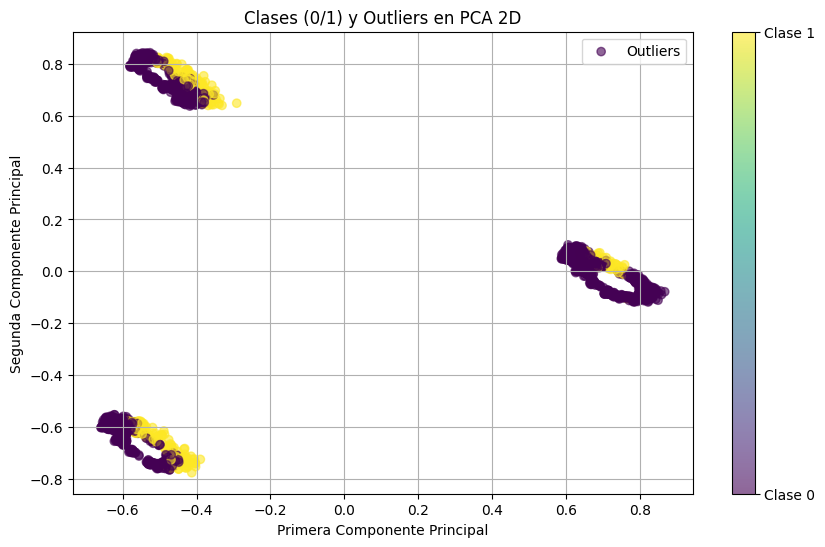

In [18]:
plt.figure(figsize=(10, 6))

plt.scatter(X_2d[y_pred == -1, 0], X_2d[y_pred == -1, 1], 
            c=y[y_pred == -1],
            cmap='viridis',
            alpha=0.6,           # Menos transparencia para destacar
            label='Outliers')

# Personalización
plt.xlabel('Primera Componente Principal')
plt.ylabel('Segunda Componente Principal')
plt.title('Clases (0/1) y Outliers en PCA 2D')
plt.legend()

# Añadir barra de colores para las clases (opcional)
cbar = plt.colorbar()
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Clase 0', 'Clase 1'])

plt.grid(True)
plt.show()

# Parte 3: HAC (5 puntos)

### 3.1 Reliza un dendograma sin clusters y con distancia threshold igual a 0 para visualizar los datos (1 punto)

In [19]:
hac = AgglomerativeClustering(n_clusters=None,
                              distance_threshold=0)
hac = hac.fit(X)

In [20]:
def plot_dendrogram(model, **kwargs):

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0]) 
    n_samples = len(model.labels_) # model.labels_: cluster labels for each point
    for i, merge in enumerate(model.children_): 
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples] # in-order enumeration of nodes
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

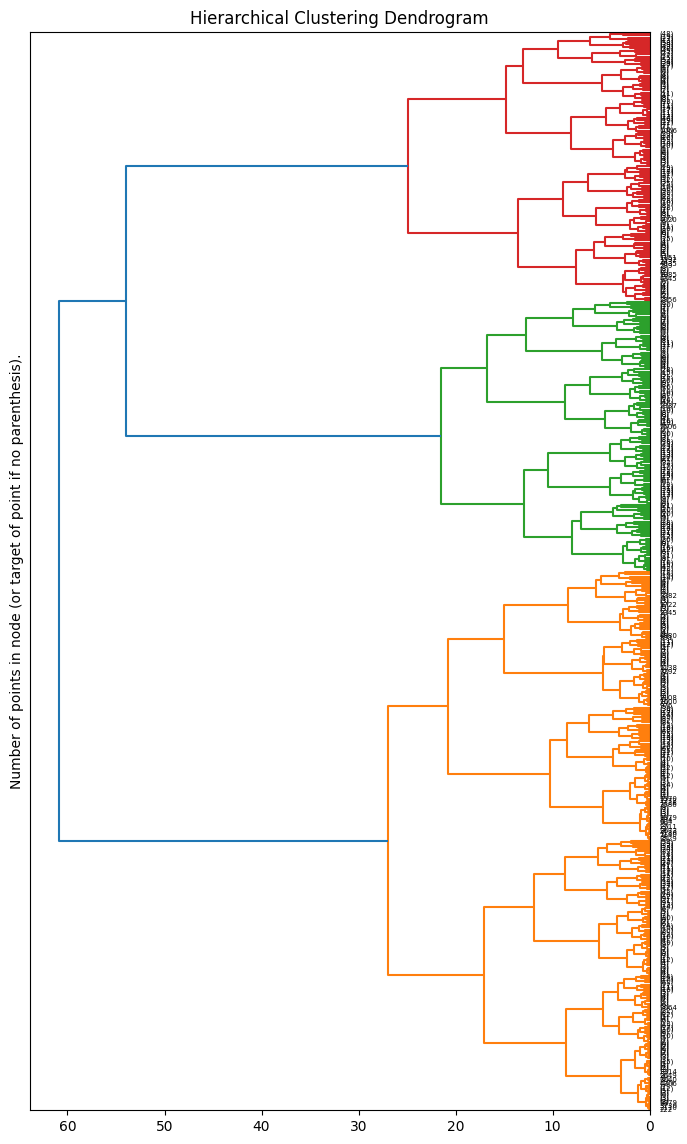

In [21]:
plt.figure(figsize=(8, 14))
plt.title("Hierarchical Clustering Dendrogram")
# Convert y to a list of strings to use as labels
labels = y.index.astype(str).tolist()
# Plot the top three levels of the dendrogram
plot_dendrogram(hac, truncate_mode="level", p=8, labels=labels, orientation='left')
plt.ylabel("Number of points in node (or target of point if no parenthesis).")
plt.show()

### 3.2 Realiza los Clustering de Agrupación Jerarquica (HAC) para cada distancia de clustering aglomerativo (linkage), prueba utilizando número entre 2 y 10. Calcula el Silhouette para ver cual funcionó mejor y explica el por qué de los resultados. (1.5 puntos)

Se espera que expliquen cuál funcionó mejor

In [22]:
X.shape

(5000, 8)

In [23]:
linkage_methods = ['ward', 'complete', 'average', 'single']
silhouette_results = {}

for linkage in linkage_methods:
    print(f"\nLinkage: {linkage}")
    silhouette_scores = []
    
    for k in range(2, 11):
        hac = AgglomerativeClustering(n_clusters=k, linkage=linkage).fit(X)
        y_pred = hac.fit_predict(X)
        score = silhouette_score(X, y_pred)
        silhouette_scores.append(score)
        print(f"  Clusters: {k} → Silhouette: {score:.4f}")
    print(np.mean(silhouette_scores).round(2))
    silhouette_results[linkage] = silhouette_scores


Linkage: ward
  Clusters: 2 → Silhouette: 0.2877
  Clusters: 3 → Silhouette: 0.4011
  Clusters: 4 → Silhouette: 0.3501
  Clusters: 5 → Silhouette: 0.3467
  Clusters: 6 → Silhouette: 0.3358
  Clusters: 7 → Silhouette: 0.3523
  Clusters: 8 → Silhouette: 0.3246
  Clusters: 9 → Silhouette: 0.3352
  Clusters: 10 → Silhouette: 0.3484
0.34

Linkage: complete
  Clusters: 2 → Silhouette: 0.2877
  Clusters: 3 → Silhouette: 0.4011
  Clusters: 4 → Silhouette: 0.3694
  Clusters: 5 → Silhouette: 0.3640
  Clusters: 6 → Silhouette: 0.2603
  Clusters: 7 → Silhouette: 0.2843
  Clusters: 8 → Silhouette: 0.2856
  Clusters: 9 → Silhouette: 0.2915
  Clusters: 10 → Silhouette: 0.2876
0.31

Linkage: average
  Clusters: 2 → Silhouette: 0.2877
  Clusters: 3 → Silhouette: 0.4011
  Clusters: 4 → Silhouette: 0.3852
  Clusters: 5 → Silhouette: 0.3811
  Clusters: 6 → Silhouette: 0.3707
  Clusters: 7 → Silhouette: 0.3634
  Clusters: 8 → Silhouette: 0.3501
  Clusters: 9 → Silhouette: 0.3408
  Clusters: 10 → Silhouett

En los resultados anteriores, podemos ver que el promedio para Ward fue 0.34, complete: 0.31, average: 0.36 y single:0.35. Con esto podemos inferir que el avergae fue quien mostro los resultados mas estables y altos en calidad de clusters. El mejor resulado individual en todos los modelos fue con k=3. Esto dice que 3 clusters podria ser una buena eleccion general independiente del linkage.

### 3.3 Ahora, realiza los Clustering de Agrupación Jerarquica (HAC) para cada tipo de linkage. Calcula el Silhouette para ver cual funcionó mejor y explica el por qué de los resultados, mencionando de que manera funciona cada linkage. Usa 20 clusters (1.5 puntos)

In [24]:
for method in linkage_methods:
    
    hac = AgglomerativeClustering(n_clusters=20, linkage=method)
    y_pred = hac.fit_predict(X)
    
    # Calcular silhouette solo si hay más de 1 cluster
    if len(set(y_pred)) > 1:
        score = silhouette_score(X, y_pred)
        print(f"Linkage: {method} → Silhouette Score: {score:.4f}")
    else:
        print(f"Linkage: {method} → No se pudo calcular silhouette (solo un cluster)")


Linkage: ward → Silhouette Score: 0.2928
Linkage: complete → Silhouette Score: 0.2527
Linkage: average → Silhouette Score: 0.3292
Linkage: single → Silhouette Score: 0.3813


El que mejor funciono fue single son 0.38 puntos, esto sucede ya que es quien mejor separa los puntos, peor lamentablemente este linkage puede sufrir de encadenamiento. Este lo que hace es unir los clusters usando la distacia minima entre puntos, tendiendo a formar estructuras alargadas, lo que puede dar estos valores altos, donde pueden haber agrupaciones poco compactas.

Complete lo que hace es usar la distancia maxima favoreciedno a clusters compactos. Average promedia la distancias y ward minimaza la varianza interna al fusionar clusters.

### 3.4 Grafica los clusters utilizando un PCA de 2 dimensiones de los datos. Usa 20 clusters y el linkage con mejor silhouette score (1 punto)

In [25]:
linkage = "single"
hac = AgglomerativeClustering(n_clusters=20, linkage=linkage)
y_pred = hac.fit_predict(X_2d)

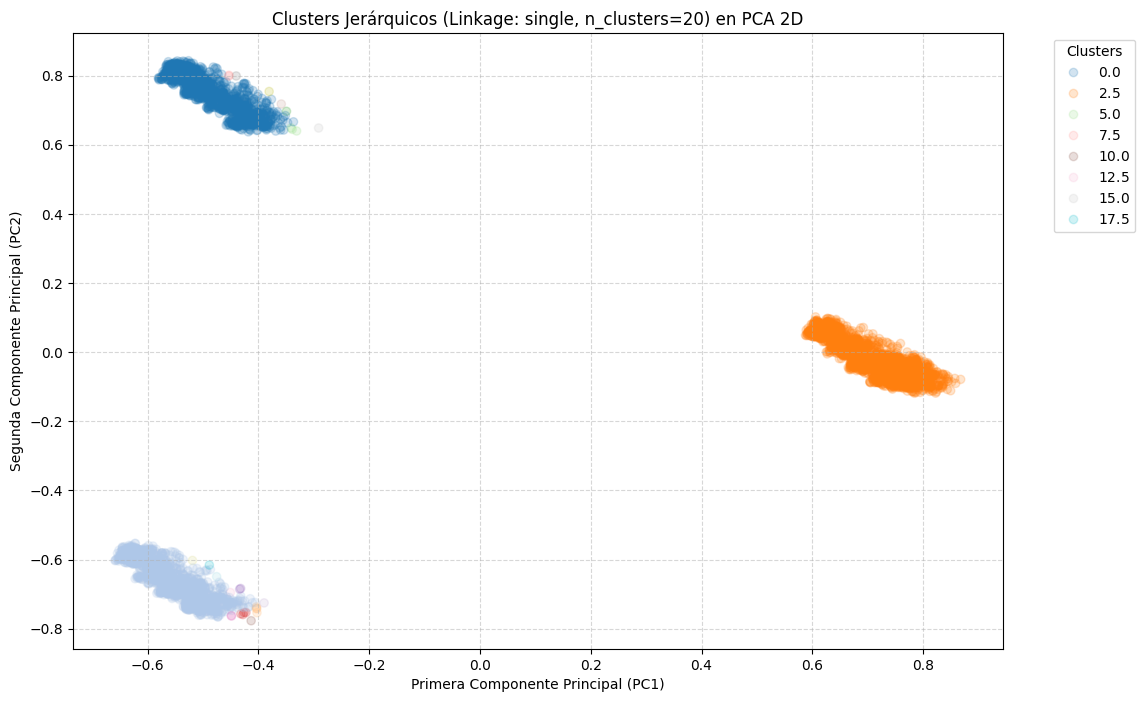

In [26]:
# 3. Graficar los clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], 
                     c=y_pred,          # Color por cluster
                     cmap='tab20',          # Paleta de 20 colores
                     alpha=0.2)

plt.xlabel('Primera Componente Principal (PC1)')
plt.ylabel('Segunda Componente Principal (PC2)')
plt.title(f'Clusters Jerárquicos (Linkage: {linkage}, n_clusters=20) en PCA 2D')

# Añadir leyenda de clusters (opcional)
legend = plt.legend(*scatter.legend_elements(), 
                    title="Clusters",
                    loc="upper right", 
                    bbox_to_anchor=(1.15, 1))

plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Con el análisis realizado, ¿Cuál es la importancia del criterio de vinculación al momento de agrupar los datos? Pruebe ahora utilizando solamente dos clusters y compare los graficos. Debe utilizar al menos un tipo de linkage para hacer la comparación.

La importacia del criterio de vinculacion al momento de agrupar los datos es que determina como se mide la distancia entre clusters durante la agrupacion jerarquica, lo cual influye diectamente en la fomra, tamaño y separacion de los grupos resultantes. Pero al usar solo dos clusters, como vemos a continuacion, los resultados visulaes son muy similares, ya que la separacion general de los datos domina sobre las diferencias sutiles.


Linkage: ward


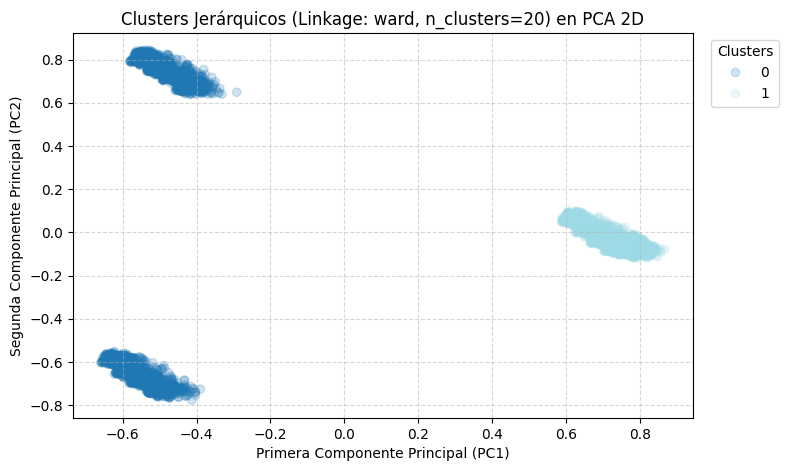


Linkage: complete


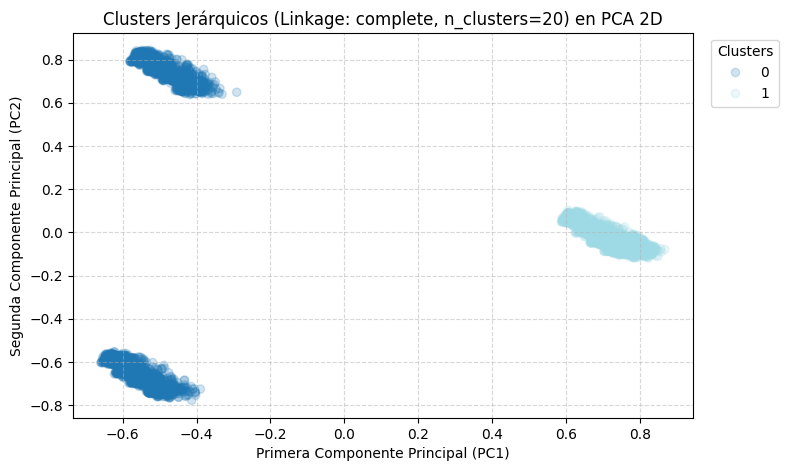


Linkage: average


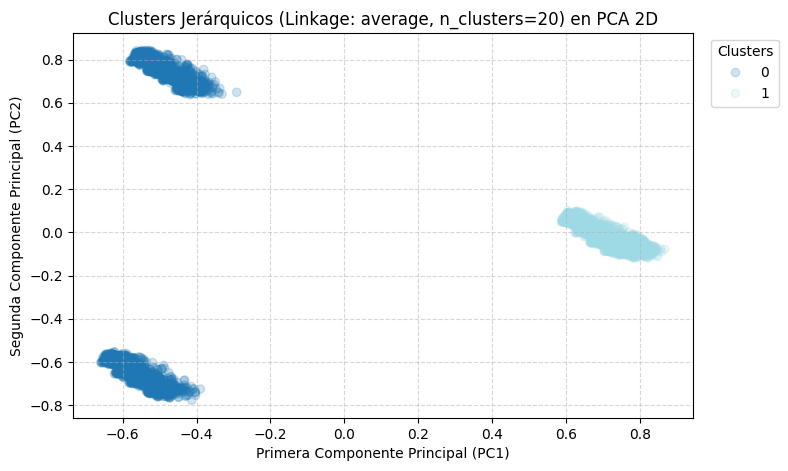


Linkage: single


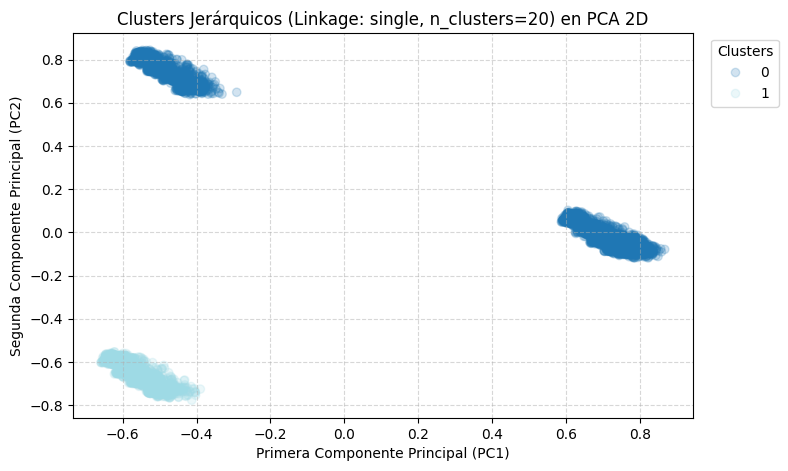

In [27]:
linkage_methods = ['ward', 'complete', 'average', 'single']
silhouette_results = {}

for linkage in linkage_methods:
    print(f"\nLinkage: {linkage}")
    silhouette_scores = []
    hac = AgglomerativeClustering(n_clusters=2, linkage=linkage).fit(X)
    y_pred = hac.fit_predict(X)

    plt.figure(figsize=(8, 5))
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], 
                        c=y_pred,          # Color por cluster
                        cmap='tab20',          # Paleta de 20 colores
                        alpha=0.2)

    plt.xlabel('Primera Componente Principal (PC1)')
    plt.ylabel('Segunda Componente Principal (PC2)')
    plt.title(f'Clusters Jerárquicos (Linkage: {linkage}, n_clusters=20) en PCA 2D')

    # Añadir leyenda de clusters (opcional)
    legend = plt.legend(*scatter.legend_elements(), 
                        title="Clusters",
                        loc="upper right", 
                        bbox_to_anchor=(1.15, 1))

    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
    

# Parte 4: DBSCAN y HDBSCAN (15 puntos)

### 4.1.- DBSCAN

Utilizando DBSCAN, itera sobre valores de eps entre 0.25 y 2, con un salto de 0.25 por iteracion. Ademas, itera sobre el numero minimo de muestras, probando con 1, 2, 3 y 4. (3 puntos)

In [28]:
eps_values = np.arange(0.25, 2.25, 0.25)
min_samples_values = [1, 2, 3, 4]
resultados = []
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        y_pred = dbscan.fit_predict(X)
        # Calcular el número de clusters (excluyendo ruido)
        n_clusters = len(set(y_pred)) - (1 if -1 in y_pred else 0)

        # Calcular silhouette score si hay al menos 2 clusters
        if n_clusters >= 2:
            score = silhouette_score(X, y_pred)
        else:
            score = None

        resultados.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'silhouette_score': score
        })

# Mostrar resultados
for r in sorted(resultados, key=lambda x: (x['silhouette_score'] is not None, x['silhouette_score']), reverse=True):
    print(f"eps: {r['eps']}, min_samples: {r['min_samples']}, clusters: {r['n_clusters']}, silhouette: {r['silhouette_score']}")

eps: 0.75, min_samples: 4, clusters: 21, silhouette: 0.40509892305473405
eps: 1.0, min_samples: 1, clusters: 3, silhouette: 0.4010806459959996
eps: 1.0, min_samples: 2, clusters: 3, silhouette: 0.4010806459959996
eps: 1.0, min_samples: 3, clusters: 3, silhouette: 0.4010806459959996
eps: 1.0, min_samples: 4, clusters: 3, silhouette: 0.4010806459959996
eps: 1.25, min_samples: 1, clusters: 3, silhouette: 0.4010806459959996
eps: 1.25, min_samples: 2, clusters: 3, silhouette: 0.4010806459959996
eps: 1.25, min_samples: 3, clusters: 3, silhouette: 0.4010806459959996
eps: 1.25, min_samples: 4, clusters: 3, silhouette: 0.4010806459959996
eps: 0.75, min_samples: 3, clusters: 24, silhouette: 0.3994681088982252
eps: 0.75, min_samples: 2, clusters: 25, silhouette: 0.39710985948886846
eps: 0.5, min_samples: 4, clusters: 24, silhouette: 0.39439525350894955
eps: 0.5, min_samples: 3, clusters: 25, silhouette: 0.39219164849820665
eps: 0.75, min_samples: 1, clusters: 28, silhouette: 0.3825681427549678
ep

#### 4.1.2 Con la información de los parametros anterior, calcula cual es el número de clusters óptimo para el modelo DBSCAN. (1.5 puntos)

**RESPUESTA:** Como podemos ver en el output anterior el numero de clusters optimo para el modelo DBSCAN, es de 22

#### 4.1.3 Determine tambien el valor optimo del parametro `eps` y `min_samples` (0.5 puntos)

**RESPUESTA:** Con el mismo output anterior, podemos ver que el eps y min_samples optimos son de 0.74 y 4 respectivamente.

#### 4.1.4 Obtenga el numero de clusters utilizando los parametros optimos encontrados. Explique por qué podría haber encontrado ese valor, el cual se puede o no ajustar al número de clases en el dataset. (1 puntos)

**RESPUESTA:** Como vimos anteriormente, el numero de clusters utilizando los parametros optimos encontrados es de 22. Pero el numero real de clases es de 2, que corresponde a Personal Loan. Esta diferencia ocurre porque DBSCAN al ser un algoritmo no supervisado, no busca ajustar grupos a las clases verdades, sino qe solo detecta las agrupaciones basadas en la densidad de los datos.

Se espera un analisis de ajuste de datos a clusters contra las clases. Puntaje por analisis y justificacion.

### 4.2.- HDBSCAN

Utilizando HDSCAN, cree un modelo con el `cluster_selection_epsilon` igual al caso de DBSCAN y determine el número de clusters. Itere sobre el min_cluster_size para encontrar el mejor silhoutte score. Compare el resultado con DBSCAN.  (3 puntos)

In [29]:
best_score = -1
best_clusters = None
best_min_cluster_size = None

for min_size in range(2, 31):
    hdb = hdbscan.HDBSCAN(min_cluster_size=min_size,
                          cluster_selection_epsilon=0.75)
    y_pred = hdb.fit_predict(X)

    # Ignorar resultados con todos -1 (todo ruido)
    if len(set(y_pred)) <= 1 or all(label == -1 for label in y_pred):
        continue
    
    score = silhouette_score(X, y_pred)
    
    if score > best_score:
        best_score = score
        best_clusters = len(set(y_pred)) - (1 if -1 in y_pred else 0)
        best_min_cluster_size = min_size

print(f"Mejor silhouette: {best_score}, clusters: {best_clusters}, min_cluster_size: {best_min_cluster_size}")


Mejor silhouette: 0.4054328883878222, clusters: 21, min_cluster_size: 5


**RESPUESTA:** Es muy parecido a DBSCAN, ya que en el nos daban 22 clusters y min_samples 4, mientras que aca nos dan 21 clusters, y min_cluster_size 5. Aunque HDBSCAN logra un ligero mejor puntaje respecto a DBSCAN: 0.4054 vs 0.4051

#### 4.2.2 Grafique los clusters utilizando PCA de 2 dimensiones. (1 punto)

In [30]:
hdb = hdbscan.HDBSCAN(min_cluster_size=5, cluster_selection_epsilon=0.75)
y_pred = hdb.fit_predict(X)

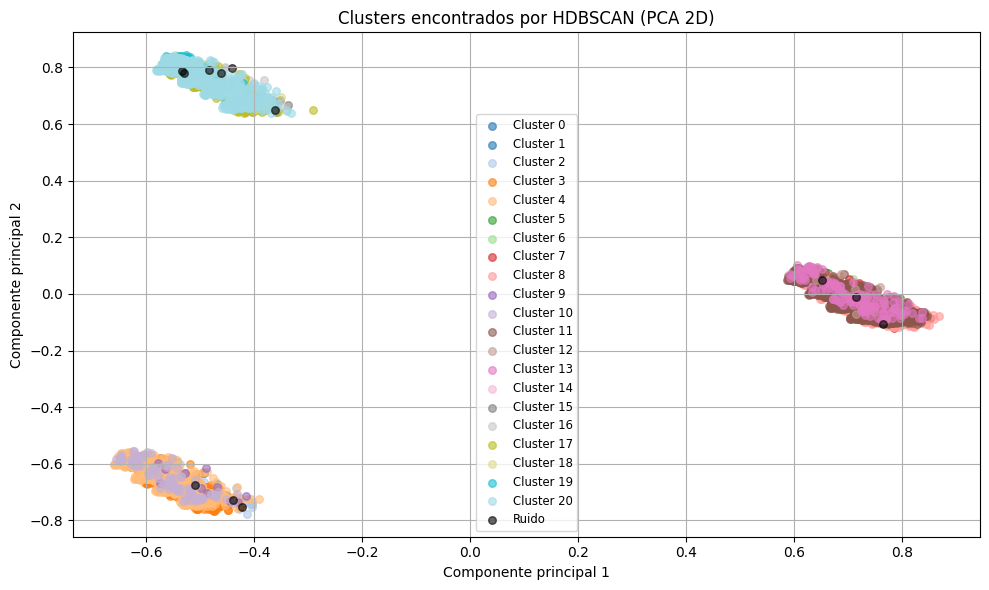

In [31]:
plt.figure(figsize=(10, 6))
palette = plt.cm.get_cmap("tab20", len(set(y_pred)))

for cluster_label in set(y_pred):
    mask = y_pred == cluster_label
    color = "k" if cluster_label == -1 else palette(cluster_label)
    plt.scatter(X_2d[mask, 0], X_2d[mask, 1], 
                label=f"Cluster {cluster_label}" if cluster_label != -1 else "Ruido",
                s=30, alpha=0.6, color=color)

plt.title("Clusters encontrados por HDBSCAN (PCA 2D)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.legend(loc='best', fontsize='small', markerscale=1)
plt.grid(True)
plt.tight_layout()
plt.show()

¿Que representa cada cluster?

**RESPUESTA:** Cada cluster representa un grupo de puntos similares segun la densidad local, por ejemplo uno podria ser de personas jovenes con altos ingresos. El ruido son puntos que no pertenecen a ningun cluster. 

### 4.4 Preguntas teoricas sobre HAC, DBSCAN y HDBSCAN (5 puntos)

#### 4.4.1 En tus palabras, ¿Cómo funciona el Agglomerative Clustering? Además, menciona al menos 2 usos para HAC.

**RESPUESTA:** El Agglomerative Clustering lo que hace es partir de cada punto como un cluster, y apartir de ahi va midiendo las distancias segun el linkage y agrupando hasta que se llega al numero deseado de estos.

Usos comunes del HAC pueden ser la segmentacion de clientes y la agrupacion de genes o muestras en bioinformatica

#### 4.4.2 Explique que representa un dendograma, mencionando cómo las ramas principales podrían significar las clases del datset.

**RESPUESTA:** Cada hoja de un dendograma respresenta un punto de datos individual, y a medida que vamos subiendo por las ramas, estos puntos se van agrupando en las ramas superiores formando los clusters. La altura de las ramas representan la distancia entre cada cluster al que se esta uniendo.

Las ramas principales, es decir las divisiones mas grandes y altas, suelen representar las clases del dataset

#### 4.4.3 En el contexto del modelo DBSCAN, ¿Que es un core sample? ¿Que podría representar un core sample en términos de un dato en el dataset? Apóyese en la clases y sus características.

**RESPUESTA:** Un core sample es un punto que tiene al menos una cantidad minima de vecinos, definida por min_samples, dentro de una distancia eps. Esto podria representar a un cliente tipico dentro de un grupo homogeneo. Ests actuan como el nucleo del cluster, y los demas puntos se agrupan en torno a ellos dentro de eps.

#### 4.4.4 En el modelo de DBSCAN se iteran sobre distintos parametros; eps y min_samples. ¿Qué representan estos parametros?

**RESPUESTA:** Como dije antes, eps hace referencia a la distancia maxima para considerar a dos puntos como vecinos, se podria pensar como el radio respecto al punto de partida. Y min_samples es el numero minimo de puntos que deben estar dentro del radio eps respecto a otro punto para que este sea considerado como core point.

#### 4.4.5 ¿Cuál es la diferencia entre DBSCAN y HDBSCAN? ¿Qué beneficios existen de usar un modelo sobre el otro?

**Respuesta** Las principales diferencias son las siguientes:

| Característica               | DBSCAN                                | HDBSCAN                                               |
|-----------------------------|----------------------------------------|--------------------------------------------------------|
| **Estructura**              | No jerárquico                          | Basado en jerarquía de densidades                     |
| **Parámetros**              | eps (radio) y min_samples          | Solo min_cluster_size; estima densidad automáticamente |
| **Robustez a densidades**   | Asume densidad constante               | Maneja múltiples densidades locales                    |
| **Ruido**                   | Detecta ruido                          | También detecta ruido, con mejor precisión             |
| **Clusters**                | Solo clusters planos                   | Permite clusters con estructura jerárquica             |

Las ventajas de HDBSCAN sobre DBSCAN, es que no requiere de eps, lo cual nos evita el trabajo de buscar un valor optimo. Detecta clusters de densidades variables, es mas estable y robusto ante ruido y outliers y produce jerarquias de clusters. La ventaja de DBSCAN frente a HDBSCAN es que es optimo si se requiere de un modelo rapido y simple.

**Para esta sección, utilize el modelo con mejor silhouette score obtenido.**

# Parte 5: Comparación y eficiencia (3 puntos)

#### 5.1 ¿Cuál de los métodos de clustering resultó ser el más eficiente entre HAC, DBSCAN, HDBSCAN o Isolation Forest? Da una explicación de por qué se puede deber el resultado.

**Respuesta**